# Converting the buried contact reflectance into refractive index

In [1]:
import funcs

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

deg = np.pi/180. # conversion factor degrees to radians

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'

In [6]:
# initialize wavelength scale and refractive indeces
wav = {}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    lamblower,lambupper = funcs.mrs_aux(band)[3]
    wav[band] = np.linspace(lamblower,lambupper,100)

n_ZnS,n_Si,n_BE,n_SiAs,n_Al = [{} for i in range(5)]
for band in wav.keys():
    n_ZnS[band]  = funcs.indexOfRefractionZnS(wav[band])
    n_Si[band]   = funcs.indexOfRefractionSi(wav[band])
    n_SiAs[band] = funcs.indexOfRefractionSiAs(wav[band])
    n_Al[band]   = funcs.indexOfRefractionAl(wav[band])

# initialize search boundaries
thickness_BE = {'1A':0.3,'1B':0.3,'1C':0.3,'2A':0.3,'2B':0.3,'2C':0.3,'3A':2.5,'3B':2.5,'3C':2.5,'4A':2.5,'4B':2.5,'4C':2.5} # um
lower_bound =  {'1A':-0.015,'1B':-0.025,'1C':-0.05,'2A':-0.1,'2B':-0.23,'2C':-0.65,'3A':-1.36,'3B':-1.13,'3C':-0.9,'4A':-0.75,'4B':-0.7,'4C':-1.05}  # um
upper_bound =  {'1A':-0.01,'1B':-0.01,'1C':-0.02,'2A':-0.035,'2B':-0.08,'2C':-0.18,'3A':-1.06,'3B':-0.85,'3C':-0.7,'4A':-0.6,'4B':-0.62,'4C':-0.65} # um

# # initialize search boundaries
# thickness_BE = {'1A':2.5,'1B':2.5,'1C':2.5,'2A':2.5,'2B':3.2,'2C':2.5,'3A':2.5,'3B':2.5,'3C':2.5,'4A':2.5,'4B':2.5,'4C':2.5} # um
# lower_bound =  {'1A':-0.06,'1B':-0.025,'1C':-0.05,'2A':-0.1,'2B':-2.3,'2C':-1.6,'3A':-1.36,'3B':-1.13,'3C':-0.9,'4A':-0.75,'4B':-0.7,'4C':-1.05}  # um
# upper_bound =  {'1A':-0.,'1B':-0.01,'1C':-0.02,'2A':-0.035,'2B':-1.6,'2C':-1.3,'3A':-1.06,'3B':-0.85,'3C':-0.7,'4A':-0.6,'4B':-0.62,'4C':-0.65} # um

<IPython.core.display.Javascript object>


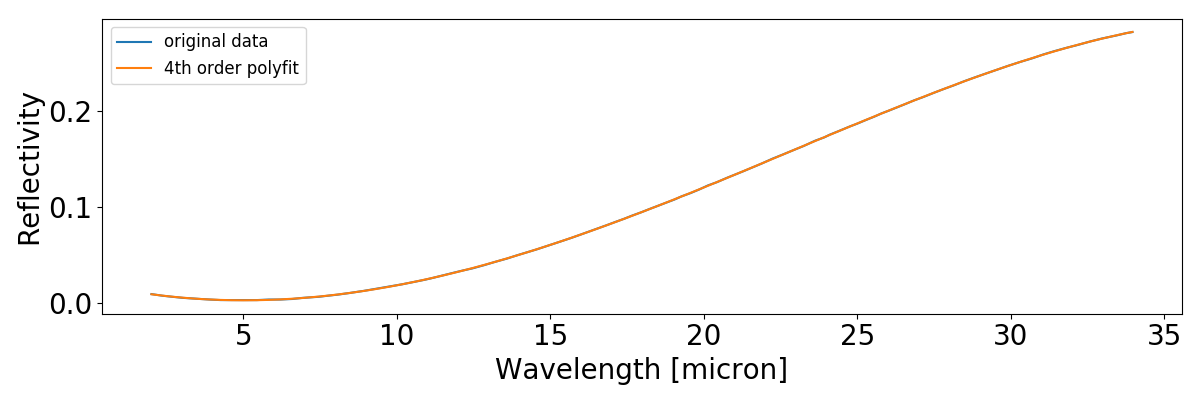

In [4]:
wav_data,transmission = np.genfromtxt('/Users/ioannisa/Desktop/python/miri_devel/transp_contact_transm_5e14implant_poly.txt',skip_header=3,usecols=(0,1),delimiter='',unpack=True)
transmission /= 100.
reflectivity_data = 1-transmission

# replace badly sampled datapoints by polynomial
popt     = np.polyfit(wav_data,reflectivity_data,4)
poly     = np.poly1d(popt)
reflectivity_BE = poly(wav_data)

plt.figure(figsize=(12,4))
plt.plot(wav_data,reflectivity_data,label='original data')
plt.plot(wav_data,reflectivity_BE,label='4th order polyfit')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Reflectivity')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

### Single band analysis

<IPython.core.display.Javascript object>


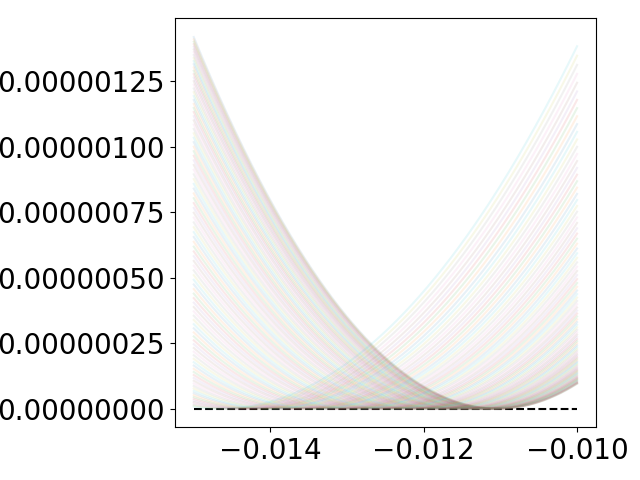

-0.011026026026 -0.0146496496496


In [19]:
plt.close('all')

band = '1A'
reflectivity_BE = poly(wav[band])
d_list_woBE = [np.inf,np.inf] # thickness, nanometers
d_list_wBE = [np.inf,thickness_BE[band]*1000., np.inf]

Refl_woBE,Transm_woBE,Absorp_woBE = [np.zeros(len(wav[band])) for i in range(3)]
Refl_wBE,Transm_wBE,Absorp_wBE = [np.zeros(len(wav[band])) for i in range(3)]
n_Si_offset = np.zeros(len(wav[band]))
plt.figure()
for i,wvl in enumerate(wav[band]):
# for i,wvl in enumerate(wav[band][-30:-27]):
#     i+=30
#     print wvl
    n_list_woBE = [1,n_Si[band][i]] # refractive index
    lambda_vac = wvl*1000 # convert microns to nanometers
    refl_BE,chi_squ = [],[]
    for offset in np.linspace(lower_bound[band],upper_bound[band],1000):
        n_BE = n_Si[band][i]+offset
        n_list_wBE = [1,n_BE,n_Si[band][i]]
        
        # solve the Fresnel equations using the Transfer-Matrix Method
        ignore,transm_woBE,ignore =  funcs.simple_tmm(n_list_woBE, d_list_woBE, 0*deg, lambda_vac)
        ignore,transm_wBE,ignore  =  funcs.simple_tmm(n_list_wBE, d_list_wBE, 0*deg, lambda_vac)
        
        transm_BE = transm_woBE/transm_wBE
        refl_BE.append(1-transm_BE)
    refl_BE = np.array(refl_BE)
    chi_squ = ((refl_BE-reflectivity_BE[i])**2)

#     # Uncomment for testing
#     plt.figure()
#     plt.title(np.linspace(lower_bound[band],upper_bound[band],1000)[chi_squ.argmin()])
#     plt.plot(np.linspace(lower_bound[band],upper_bound[band],1000),refl_BE)
#     plt.hlines(reflectivity_BE[i],lower_bound[band],upper_bound[band],'k',linestyle='dashed')
#     plt.tight_layout()
    
    plt.plot(np.linspace(lower_bound[band],upper_bound[band],1000),chi_squ,alpha=0.1)
    
    n_Si_offset[i] = np.linspace(lower_bound[band],upper_bound[band],1000)[chi_squ.argmin()]
plt.hlines(0,lower_bound[band],upper_bound[band],'k',linestyle='dashed')
plt.tight_layout()
print n_Si_offset[0],n_Si_offset[-1]

<IPython.core.display.Javascript object>


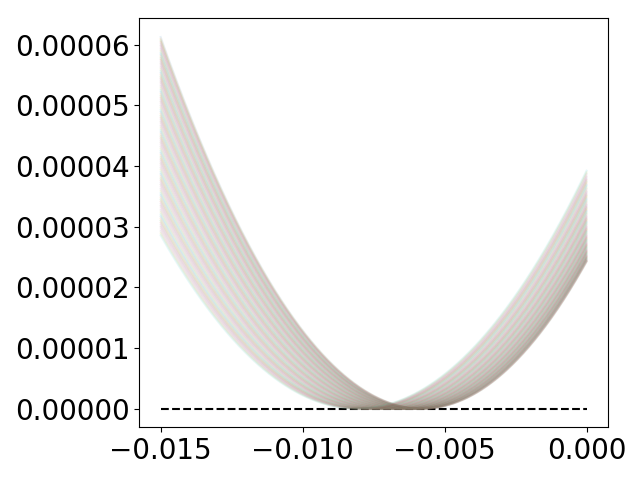

-0.00576576576577 -0.00807807807808


In [7]:
plt.close('all')

band = '1A'
reflectivity_BE = poly(wav[band])
d_list_woBE = [np.inf,np.inf] # thickness, nanometers
d_list_wBE = [np.inf,thickness_BE[band]*1000., np.inf]

Refl_woBE,Transm_woBE,Absorp_woBE = [np.zeros(len(wav[band])) for i in range(3)]
Refl_wBE,Transm_wBE,Absorp_wBE = [np.zeros(len(wav[band])) for i in range(3)]
n_Si_offset = np.zeros(len(wav[band]))
plt.figure()
for i,wvl in enumerate(wav[band]):
# for i,wvl in enumerate(wav[band][-30:-27]):
#     i+=30
#     print wvl
    n_list_woBE = [1,n_SiAs[band][i]] # refractive index
    lambda_vac = wvl*1000 # convert microns to nanometers
    refl_BE,chi_squ = [],[]
    for offset in np.linspace(lower_bound[band],upper_bound[band],1000):
        n_BE = complex(n_SiAs[band][i].real,n_SiAs[band][i].imag+offset)
        n_list_wBE = [1,n_BE,n_Si[band][i]]
        
        # solve the Fresnel equations using the Transfer-Matrix Method
        ignore,transm_woBE,ignore =  funcs.simple_tmm(n_list_woBE, d_list_woBE, 0*deg, lambda_vac)
        ignore,transm_wBE,ignore  =  funcs.simple_tmm(n_list_wBE, d_list_wBE, 0*deg, lambda_vac)
        
        transm_BE = transm_woBE/transm_wBE
        refl_BE.append(1-transm_BE)
    refl_BE = np.array(refl_BE)
    chi_squ = ((refl_BE-reflectivity_BE[i])**2)

#     # Uncomment for testing
#     plt.figure()
#     plt.title(np.linspace(lower_bound[band],upper_bound[band],1000)[chi_squ.argmin()])
#     plt.plot(np.linspace(lower_bound[band],upper_bound[band],1000),refl_BE)
#     plt.hlines(reflectivity_BE[i],lower_bound[band],upper_bound[band],'k',linestyle='dashed')
#     plt.tight_layout()
    
    plt.plot(np.linspace(lower_bound[band],upper_bound[band],1000),chi_squ,alpha=0.1)
    
    n_Si_offset[i] = np.linspace(lower_bound[band],upper_bound[band],1000)[chi_squ.argmin()]
plt.hlines(0,lower_bound[band],upper_bound[band],'k',linestyle='dashed')
plt.tight_layout()
print n_Si_offset[0],n_Si_offset[-1]

<IPython.core.display.Javascript object>


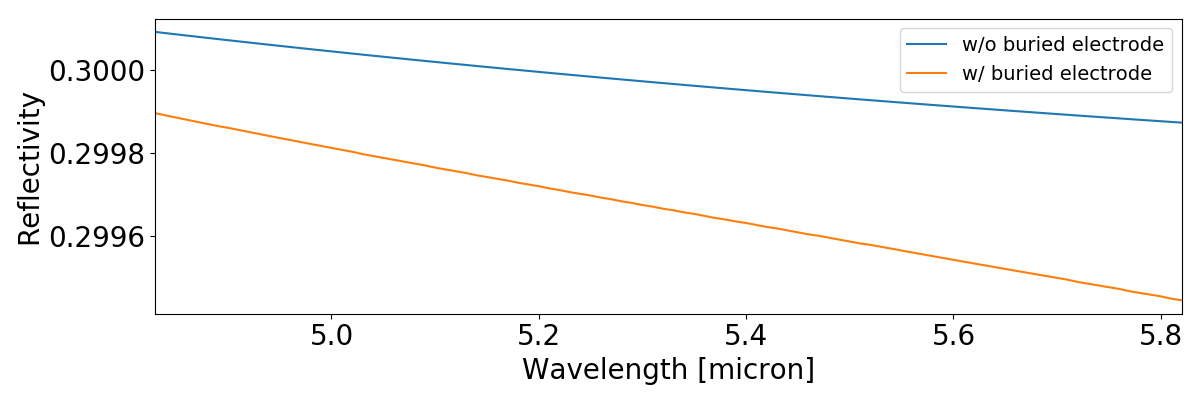

<IPython.core.display.Javascript object>


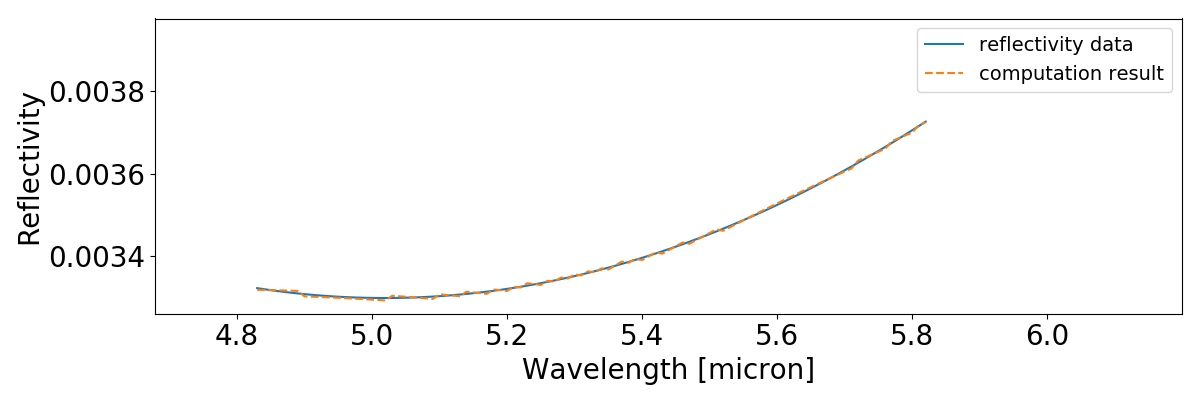

<IPython.core.display.Javascript object>


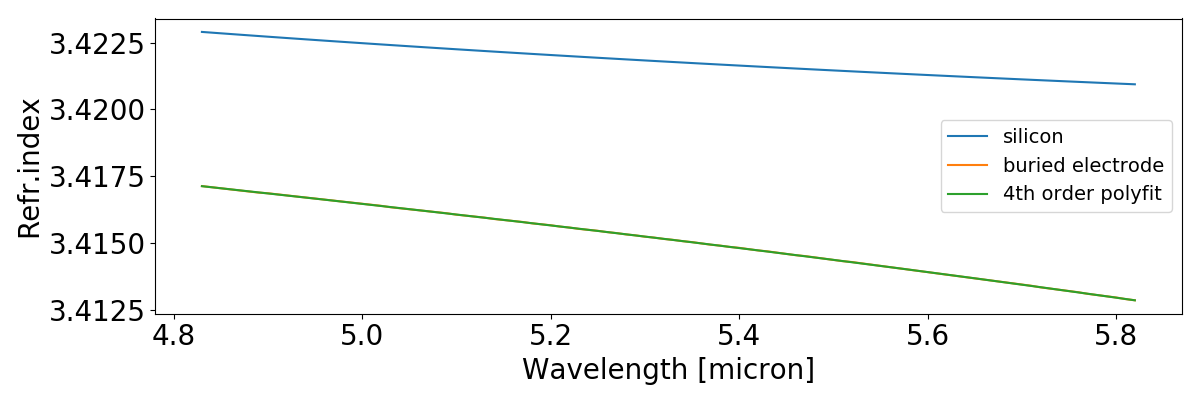

In [8]:
Refl_woBE,Transm_woBE,Absorp_woBE = [np.zeros(len(wav[band])) for i in range(3)]
Refl_wBE,Transm_wBE,Absorp_wBE = [np.zeros(len(wav[band])) for i in range(3)]
for i,wvl in enumerate(wav[band]):
    n_BE = complex(n_SiAs[band][i].real,n_SiAs[band][i].imag+n_Si_offset[i])
    # define stack of refractive layers
    n_list_woBE = [1,n_Si[band][i]] # refractive index
    n_list_wBE = [1,n_BE,n_Si[band][i]]
    lambda_vac = wvl*1000 # convert microns to nanometers
    # solve the Fresnel equations using the Transfer-Matrix Method
    Refl_woBE[i],Transm_woBE[i],Absorp_woBE[i] =  funcs.simple_tmm(n_list_woBE, d_list_woBE, 0*deg, lambda_vac)
    Refl_wBE[i],Transm_wBE[i],Absorp_wBE[i] =  funcs.simple_tmm(n_list_wBE, d_list_wBE, 0*deg, lambda_vac)
Transm_BE = Transm_woBE/Transm_wBE
Refl_BE   = 1-Transm_BE
n_BE = n_Si[band]+n_Si_offset

# fit polynomial to result
popt_nBE = np.polyfit(wav[band],n_BE,4)
poly_nBE     = np.poly1d(popt_nBE)
lamblower,lambupper = funcs.mrs_aux(band)[3]
fitted_nBE = poly_nBE(np.linspace(lamblower,lambupper,1000))
    
plt.figure(figsize=(12,4))
plt.plot(wav[band],Refl_woBE,label='w/o buried electrode')
plt.plot(wav[band],Refl_wBE,label='w/ buried electrode')
plt.xlim(wav[band][0],wav[band][-1])
plt.xlabel('Wavelength [micron]')
plt.ylabel('Reflectivity')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(wav[band],poly(wav[band]),label='reflectivity data')
plt.plot(wav[band],Refl_BE,linestyle='dashed',label='computation result')
plt.xlim(wav[band][0],wav[band][-1])
# plt.ylim(0.,0.01)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Reflectivity')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(wav[band],n_Si[band],label='silicon')
plt.plot(wav[band],n_Si[band]+n_Si_offset,label='buried electrode')
plt.plot(np.linspace(lamblower,lambupper,1000),fitted_nBE,label='4th order polyfit')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Refr.index')
plt.legend(loc='center right')
plt.tight_layout()

### Multi-band analysis

In [5]:
# initialize placeholder
fitted_nBE = {}

In [8]:
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    print 'Band {}'.format(band)
    reflectivity_BE = poly(wav[band])
    d_list_woBE = [np.inf,np.inf] # thickness, nanometers
    d_list_wBE = [np.inf,thickness_BE[band]*1000., np.inf]
    
    n_Si_offset = np.zeros(len(wav[band]))
    for i,wvl in enumerate(wav[band]):
        n_list_woBE = [1,n_Si[band][i]] # refractive index
        lambda_vac = wvl*1000 # convert microns to nanometers
        refl_BE,chi_squ = [],[]
        for offset in np.linspace(lower_bound[band],upper_bound[band],1000):
            n_BE = n_Si[band][i]+offset
            n_list_wBE = [1,n_BE,n_Si[band][i]]

            # solve the Fresnel equations using the Transfer-Matrix Method
            ignore,transm_woBE,ignore =  funcs.simple_tmm(n_list_woBE, d_list_woBE, 0*deg, lambda_vac)
            ignore,transm_wBE,ignore  =  funcs.simple_tmm(n_list_wBE, d_list_wBE, 0*deg, lambda_vac)

            transm_BE = transm_woBE/transm_wBE
            refl_BE.append(1-transm_BE)
        refl_BE = np.array(refl_BE)
        chi_squ = ((refl_BE-reflectivity_BE[i])**2)
        n_Si_offset[i] = np.linspace(lower_bound[band],upper_bound[band],1000)[chi_squ.argmin()]
    print n_Si_offset[0],n_Si_offset[-1]
    n_BE = n_Si[band]+n_Si_offset
    
    # fit polynomial to result
    popt_nBE = np.polyfit(wav[band],n_BE,4)
    poly_nBE = np.poly1d(popt_nBE)
    lamblower,lambupper = funcs.mrs_aux(band)[3]
    if band == '3C':
        fitted_nBE[band] = n_BE.copy()
    else:
        fitted_nBE[band] = poly_nBE(np.linspace(lamblower,lambupper,1000))

Band 1A
-0.011026026026 -0.0146496496496
Band 1B
-0.0133933933934 -0.0247597597598
Band 1C
-0.0209009009009 -0.0483483483483
Band 2A
-0.0392942942943 -0.0985685685686
Band 2B
-0.0825525525526 -0.220540540541
Band 2C
-0.180940940941 -0.626946946947
Band 3A
-1.3593993994 -1.07141141141
Band 3B
-1.12159159159 -0.855605605606
Band 3C
-0.899399399399 -0.701601601602
Band 4A
-0.736336336336 -0.634984984985
Band 4B
-0.640660660661 -0.690870870871
Band 4C
-0.664014014014 -1.03118118118


In [ ]:
all_wav_CH12,all_fitted_nBE_CH12 = [],[]
for band in ['1A','1B','1C','2A','2B','2C']:
    lamblower,lambupper = funcs.mrs_aux(band)[3]
    all_wav_CH12.extend(np.linspace(lamblower,lambupper,1000))
    all_fitted_nBE_CH12.extend(fitted_nBE[band])

all_fitted_nBE_CH12_sorted = [x for _,x in sorted(zip(all_wav_CH12,all_fitted_nBE_CH12))]
all_wav_sorted_CH12 = sorted(all_wav_CH12)

all_wav_CH34,all_fitted_nBE_CH34 = [],[]
for band in ['3A','3B','3C','4A','4B','4C']:
    lamblower,lambupper = funcs.mrs_aux(band)[3]
    all_wav_CH34.extend(np.linspace(lamblower,lambupper,1000))
    all_fitted_nBE_CH34.extend(fitted_nBE[band])

all_fitted_nBE_CH34_sorted = [x for _,x in sorted(zip(all_wav_CH34,all_fitted_nBE_CH34))]
all_wav_sorted_CH34 = sorted(all_wav_CH34)

plt.figure(figsize=(12,4))
for band in wav.keys(): plt.plot(wav[band],n_Si[band],'k')
plt.plot(all_wav_sorted_CH12,all_fitted_nBE_sorted_CH12)
plt.plot(all_wav_sorted_CH34,all_fitted_nBE_sorted_CH34)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Refr.index')
plt.tight_layout()

In [14]:
f = open("optical_constants_BE_2.5um.txt", "w")
for i in xrange(len(all_wav_sorted)):
    f.write("{}\t\t{}\t{}\n".format(all_wav_sorted[i],np.real(all_fitted_nBE_sorted[i]), 0.))
f.close()